# MMA 2022S 865, Individual Assignment 1

Version 2: Updated January 1, 2022.

- Gopala Goyal
- 20254605
- 2
- January 8, 2022

# Question 1 - ELI5

_“If you can't explain it simply, you don't understand it well enough.” – Albert Einstein_

Explaining technical concepts to a non-technical audience is an underappreciated skill; one which the GMMA/MMA program aims to give its students; and one that will truly set you apart in the job market. The only way to gain a skill is by practice, so here we go.

Answer each question below as though you were talking to a 5 year old (equivalently: a grandma, or a completely non-technical manager, or an Ivey grad). Use your own words. Use analogies where possible. Examples are better than theory. Keep it short, but be complete. Use simple, plain English. Do not use business buzzwords like _actualize, empower, fungible, leverage, or synergize_. Do not use technical buzzwords that most people don’t know like _model, agile, bandwidth, IoT, blockchain, AR, VR, actionable insights_. Inform the audience without going into too much technical detail. Your goal is to truly help them understand, not to give what you feel is a “technically precise” answer and move on (but they still don’t understand!). Don’t be that guy!

Please keep each answer to 1000 characters or less.

Finally, feel free to use [Markdown syntax](https://www.markdownguide.org/basic-syntax/) to format your answer.


### Part 1: What is “Big Data” and how is it different than “regular data”?

TODO: Insert your answer here.

### Part 2: What is Hadoop? Hint: What problems in previous data storage and processing was Hadoop designed to solve? How did Hadoop accomplish that?

TODO: Insert your answer here.

### Part 3: How does Big Data and the cloud help Machine Learning? 

TODO: Insert your answer here.

### Part 4: What is NoSQL?

TODO: Insert your answer here.

### Part 5: Name three ways topic modeling could help a bank.

TODO: Insert your answer here.

### Part 6: What is Apache Spark, exactly, and what are its pros and cons?

TODO: Insert your answer here.

# Question 2: Sentiment Analysis via the ML-based approach

Download the “Product Sentiment” dataset from the course portal: sentiment_train.csv and sentiment_test.csv.

### Part 1.a. Loading and Prep

Load, clean, and preprocess the data as you find necessary.

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, KFold, GridSearchCV

from pycaret.classification import *

In [32]:
#nltk.download("all")

In [193]:
# TODO: import other libraries as necessary

df_train = pd.read_csv("sentiment_train.csv")

print(df_train.info())
print(df_train.head())

df_test = pd.read_csv("sentiment_test.csv")

print(df_test.info())
print(df_test.head())

# TODO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB
No

### EDA

<AxesSubplot:>

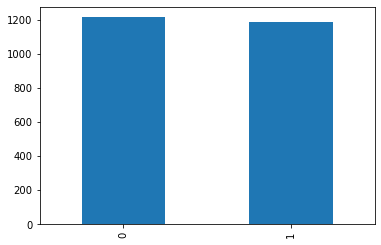

In [68]:
df_train.Polarity.value_counts().plot.bar()

> Data is balanced

### Check missing/wrong values

In [194]:
def createLengthCol(dataframe,col):
    dataframe['review_length']  = dataframe[col].str.split().str.len()

In [195]:
createLengthCol(df_train,'Sentence')
df_train[df_train.review_length==1]

,Sentence,Polarity,review_length
26,#NAME?,0,1
71,#NAME?,1,1
165,DELICIOUS!!,1,1
219,#NAME?,1,1
904,#NAME?,0,1
1185,Incredible!.,1,1
1463,Disappointed!.,0,1
1751,disappointing.,0,1
1777,WORTHWHILE.,1,1
1877,Excellent!.,1,1


> We need to remove the rows with data as '#NAME?'

In [196]:
df_train = df_train.drop(df_train[df_train.Sentence == "#NAME?"].index).reset_index(drop = True)

In [197]:
df_train.head(2)

,Sentence,Polarity,review_length
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4


#### Method to clean data

In [198]:
#Method to clean data
#Remove punctuations
#Remove numbers
#Lowercase the string
#Split the strings on white spaces
#Remove Stopwords
#Lemmatization

lemmatizer = WordNetLemmatizer()
def text_cleaner(text):
    r = re.sub(r'[^\w\s]', ' ', text)
    r = r.translate(str.maketrans("","",string.punctuation)) 
    r = re.sub(r'\d+', '',r) 
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    return r

In [199]:
df_train['clean_sentence'] = df_train.Sentence.apply(lambda text:text_cleaner(text))
createLengthCol(df_train,'clean_sentence')

#### Separate Features with Label

In [200]:
X = df_train.drop(columns  = ["Polarity"])
y = df_train.Polarity

#### Apply TF-IDF on cleaned sentence feature

In [201]:
cv = CountVectorizer()
X_cv = cv.fit_transform(X.clean_sentence)

In [202]:
X = pd.concat([X,pd.DataFrame(data=X_cv.toarray(), columns = cv.get_feature_names())],axis = 1).drop(columns = ['Sentence','clean_sentence'])

#### Preprocessing on Test

In [203]:
df_test.head(2)

,Sentence,Polarity
0,A good commentary of today's love and undoubte...,1
1,For people who are first timers in film making...,1


In [204]:
createLengthCol(df_test,'Sentence')
print(df_test[df_test.review_length==1])
df_test['clean_sentence'] = df_test.Sentence.apply(lambda text:text_cleaner(text))
createLengthCol(df_test,'clean_sentence')

    Sentence  Polarity  review_length
388   10-Oct         1              1


In [205]:
X_test = df_test.drop(columns  = ["Polarity"])
y_test = df_test.Polarity

In [206]:
X_test_cv = cv.transform(X_test.clean_sentence)
X_test = pd.concat([X_test,pd.DataFrame(data=X_test_cv.toarray(), columns = cv.get_feature_names())],axis = 1).drop(columns = ['Sentence','clean_sentence'])

In [207]:
X_test.head(2)

,review_length,abhor,ability,able,abound,absolute,absolutel,absolutely,absolutley,abstruse,...,yet,young,youthful,yucky,yukon,yum,yummy,za,zero,zombiez
0,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Part 1.b. Modeling

Use your favorite ML algorithm to train a classification model.  Don’t forget everything that we’ve learned in our ML course: hyperparameter tuning, cross validation, handling imbalanced data, etc. Make reasonable decisions and try to create the best-performing classifier that you can.

#### Logistic Regression base model with 10 fold Cross Validation

In [208]:
lr = LogisticRegression()

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro',
           'f1_macr':'f1_macro',
           'roc_auc':'roc_auc'}
scores = pd.DataFrame(cross_validate(lr, X=X, y=y,scoring=scoring, cv=10, n_jobs=-1))

In [209]:
scores.test_f1_macr.sort_values()

9    0.736709
8    0.740556
0    0.749844
6    0.772910
3    0.787467
1    0.789562
4    0.820756
2    0.829021
5    0.829021
7    0.840532
Name: test_f1_macr, dtype: float64

In [210]:
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Logistic Regression Hyperparameter Tuned Model

In [215]:
param_dict = {
'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]    
}

# define search
search = GridSearchCV(lr, param_dict, scoring='f1_macro', n_jobs=-1, cv=10)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7896377815616248
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [219]:
lr_tuned = LogisticRegression(C=1, penalty='l2',solver='newton-cg')
scores_tuned = pd.DataFrame(cross_validate(lr_tuned, X=X, y=y,scoring=scoring, cv=10, n_jobs=-1))
scores_tuned

,fit_time,score_time,test_acc,test_prec_macro,test_rec_micro,test_f1_macr,test_roc_auc
0,5.996212,0.155026,0.750000,0.750261,0.749844,0.749844,0.863115
1,6.070194,0.127702,0.791667,0.801961,0.790888,0.789562,0.878742
2,5.958574,0.168687,0.829167,0.829783,0.828981,0.829021,0.902702
3,5.720132,0.289310,0.787500,0.787959,0.787659,0.787467,0.872422
4,5.387379,0.259070,0.820833,0.821846,0.821064,0.820756,0.915966
5,5.310086,0.205536,0.829167,0.829391,0.828911,0.829021,0.907335
6,5.865655,0.236186,0.774059,0.777920,0.773288,0.772910,0.864407
7,5.763474,0.236005,0.841004,0.843582,0.840454,0.840532,0.885278
8,2.942499,0.131701,0.748954,0.780618,0.746813,0.740556,0.810618
9,3.115625,0.092872,0.740586,0.752514,0.739179,0.736709,0.797276


In [220]:
lr_tuned.fit(X,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

### Part 1.c. Assessing

Use the testing data to measure the accuracy and F1-score of your model.  

In [211]:
predictions = lr.predict(X_test)

In [212]:
metrics.confusion_matrix(y_test,predictions)

array([[254,  33],
       [112, 201]])

In [213]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       287
           1       0.86      0.64      0.73       313

    accuracy                           0.76       600
   macro avg       0.78      0.76      0.76       600
weighted avg       0.78      0.76      0.76       600



#### After Hyperparameter Tuning

In [221]:
tuned_predictions = lr_tuned.predict(X_test)
print(metrics.confusion_matrix(y_test,tuned_predictions))
print(classification_report(y_test,tuned_predictions))

[[254  33]
 [112 201]]
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       287
           1       0.86      0.64      0.73       313

    accuracy                           0.76       600
   macro avg       0.78      0.76      0.76       600
weighted avg       0.78      0.76      0.76       600



In [222]:
df_test_pred = df_test
df_test_pred['predictions'] = tuned_predictions
df_test_pred[df_test_pred.Polarity != predictions]

,Sentence,Polarity,review_length,clean_sentence,predictions
4,It has northern humour and positive about the ...,1,5,northern humour positive community represents,0
8,It really created a unique feeling though.,1,5,really created unique feeling though,0
12,Not too screamy not to masculine but just righ...,1,3,screamy masculine right,0
13,The camera really likes her in this movie.,1,4,camera really like movie,0
14,I would have casted her in that role after rea...,1,5,would casted role ready script,0
...,...,...,...,...,...
581,I keep watching it over and over.,1,2,keep watching,0
584,"She is as lovely as usual, this cutie!",1,3,lovely usual cutie,0
588,It was a riot to see Hugo Weaving play a sex-o...,1,19,riot see hugo weaving play sex obsessed gay re...,0
589,":) Anyway, the plot flowed smoothly and the ma...",1,8,anyway plot flowed smoothly male bonding scene...,0


### Part 2. Given the accuracy and F1-score of your model, are you satisfied with the results, from a business point of view? Explain.

- It really depends upon the problem which we are trying to solve using this model. 
- As accuracy, is simply the ratio of correctly predicted observations to the total observations. For our model, we have got accuracy of 76% which is reasonable, however, we would have to look other performance metric like F1-score to evaluate our model. 
- The F1 score is weighted average of precision and recall (or sensitivity). The precision metric answers the question that from the customers the model labeled as 1, how many actually were correctly labeled as 1. High precision is related to low false positive rates. Our precision is about 86% which is good. 
- On the other hand, Recall is the ratio of correctly predicted positive obersvations to all the observations in the actual class label=1. As mentioned above, our Recall is 69% which is reasonable, however, not as good as precision. Therefore, Recall is taking a hit on F1 score, which is 78%. 
- It interpretation can further be explained by confusion matrix below and we can see that False Negative are considerably higher in number as compared to False Positives.
[[254  33]
 [112 201]]
- Therefore, our model is predicting sentiment of 0 when actually the sentiment was 1. Hence, depending upon what is the use case of utilizing the negative sentiment, we would have to be careful in dealing with the negative values that this model is predicting.

### Part 3. Show five example instances in which your model’s predictions were incorrect. Describe why you think the model was wrong. Don’t just guess: dig deep to figure out the root cause.

TODO: Insert your answer here.

In [55]:
# TODO: Feel free to use code as well to answer this question. Or not. Up to you.

## TESTING PYCARET CLASSIFICATION

In [59]:
X_pyc = X
X_pyc['Polarity'] = y

In [60]:
mo = setup(data = X_pyc, target = 'Polarity')

,Description,Value
0,session_id,8185
1,Target,Polarity
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2396, 3630)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,3628
8,Ordinal Features,False
9,High Cardinality Features,False


In [62]:
cl = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7841,0.8581,0.7391,0.8009,0.7679,0.5668,0.5693,7.7710
ridge,Ridge Classifier,0.7758,0.0000,0.7600,0.7748,0.7662,0.5508,0.5524,0.3840
et,Extra Trees Classifier,0.7597,0.8370,0.7540,0.7511,0.7522,0.5189,0.5193,1.6860
rf,Random Forest Classifier,0.7496,0.8364,0.6961,0.7651,0.7283,0.4972,0.4996,1.0790
catboost,CatBoost Classifier,0.7466,0.8444,0.6051,0.8257,0.6970,0.4885,0.5067,34.2640
gbc,Gradient Boosting Classifier,0.7430,0.8024,0.5781,0.8443,0.6849,0.4806,0.5061,1.8320
xgboost,Extreme Gradient Boosting,0.7347,0.8193,0.6396,0.7742,0.7000,0.4661,0.4733,12.7320
ada,Ada Boost Classifier,0.7334,0.7862,0.5658,0.8330,0.6729,0.4613,0.4868,0.6510
dt,Decision Tree Classifier,0.7269,0.7308,0.7392,0.7098,0.7238,0.4539,0.4547,0.4030
nb,Naive Bayes,0.6947,0.6990,0.8523,0.6396,0.7303,0.3948,0.4178,0.1870
